In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import yaml
import pprint
import os
import time
# weights and biases for tracking of metrics
import wandb 
# make the plots inline again
%matplotlib inline
# sometimes have to activate this to plot plots in notebook
# matplotlib.use('Qt5Agg')
from code import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
from collections import Counter

from random import randint
import time
from power_spherical import PowerSpherical


def T_spherical_to_cartesian(phi,theta):
    """
    3d transformation between spherical and euclidean coordinates. 
    NOTE: Convention see vMF dataset class

    Args: 
        phi (batch,1) - angle in x-y plane
        theta (batch,1) z axis evelation
    Returns: 
        x vector (shape,3)
    """
    
    # "usual" convention
    # x = np.sin(phi) * np.cos(theta)
    # y = np.sin(phi) * np.sin(theta)
    # z = np.cos(phi)

    # "my" convention where theta measures elevation from x-y plane
    x = np.cos(theta) * np.cos(phi)
    y = np.cos(theta) * np.sin(phi)
    z = np.sin(theta)

    return np.array([x, y, z]).T

def T_cartesian_to_spherical(x, y, z):
    """
    3d transformation between spherical and euclidean coordinates theta is the angle. 
    NOTE: Convention see vMF dataset class
    """
    
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    phi = np.arctan2(y, x) # range [-pi, pi]
    theta = np.arcsin(z / r) # range [-pi/2, pi/2]
    
    return np.array([r, phi, theta]).T

# need to add PROJ LIB for basemap
import os
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as tck

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:

from numpy import *
from scipy.optimize import fmin_bfgs
from scipy.special import gamma as gamma_fun
from scipy.special import iv as modified_bessel_2ndkind
from scipy.special import ivp as modified_bessel_2ndkind_derivative
from scipy.stats import uniform
# to avoid confusion with the norm of a vector we give the normal distribution a less confusing name here
from scipy.stats import norm as gauss 
from scipy.linalg import eig
import sys
import warnings


#helper function
def MMul(A, B):
  return inner(A, transpose(B))

#helper function to compute the L2 norm. scipy.linalg.norm is not used because this function does not allow to choose an axis
def norm(x, axis=None):
  if isinstance(x, list) or isinstance(x, tuple):
    x = array(x)
  return sqrt(sum(x*x, axis=axis))
  
def kent(theta, phi, psi, kappa, beta):
  """
  Generates the Kent distribution based on the spherical coordinates theta, phi, psi
  with the concentration parameter kappa and the ovalness beta
  """
  gamma1, gamma2, gamma3 = KentDistribution.spherical_coordinates_to_gammas(theta, phi, psi)
  k = KentDistribution(gamma1, gamma2, gamma3, kappa, beta)
  return k

def kent2(gamma1, gamma2, gamma3, kappa, beta):
  """
  Generates the Kent distribution using the orthonormal vectors gamma1, 
  gamma2 and gamma3, with the concentration parameter kappa and the ovalness beta
  """
  assert abs(inner(gamma1, gamma2)) < 1E-10
  assert abs(inner(gamma2, gamma3)) < 1E-10
  assert abs(inner(gamma3, gamma1)) < 1E-10
  return KentDistribution(gamma1, gamma2, gamma3, kappa, beta)
    
def kent3(A, B):
  """
  Generates the Kent distribution using the orthogonal vectors A and B
  where A = gamma1*kappa and B = gamma2*beta (gamma3 is inferred)
  A may have not have length zero but may be arbitrarily close to zero
  B may have length zero however. If so, then an arbitrary value for gamma2
  (orthogonal to gamma1) is chosen
  """
  kappa = norm(A)
  beta = norm(B)
  gamma1 = A/kappa
  if beta == 0.0:
    gamma2 = __generate_arbitrary_orthogonal_unit_vector(gamma1)
  else:
    gamma2 = B/beta
  theta, phi, psi = KentDistribution.gammas_to_spherical_coordinates(gamma1, gamma2)
  gamma1, gamma2, gamma3 = KentDistribution.spherical_coordinates_to_gammas(theta, phi, psi)
  return KentDistribution(gamma1, gamma2, gamma3, kappa, beta)
  
def kent4(Gamma, kappa, beta):
  """
  Generates the kent distribution
  """
  gamma1 = Gamma[:,0]
  gamma2 = Gamma[:,1]
  gamma3 = Gamma[:,2]
  return kent2(gamma1, gamma2, gamma3, kappa, beta)

def __generate_arbitrary_orthogonal_unit_vector(x):
  v1 = cross(x, array([1.0, 0.0, 0.0]))
  v2 = cross(x, array([0.0, 1.0, 0.0]))
  v3 = cross(x, array([0.0, 0.0, 1.0]))
  v1n = norm(v1)
  v2n = norm(v2)
  v3n = norm(v3)
  v = [v1, v2, v3][argmax([v1n, v2n, v3n])]
  return v/norm(v)
  
class KentDistribution(object):
  minimum_value_for_kappa = 1E-6
  @staticmethod
  def create_matrix_H(theta, phi):
    return array([
      [cos(theta),          -sin(theta),         0.0      ],
      [sin(theta)*cos(phi), cos(theta)*cos(phi), -sin(phi)],
      [sin(theta)*sin(phi), cos(theta)*sin(phi), cos(phi) ]
    ])

  @staticmethod
  def create_matrix_Ht(theta, phi):
    return transpose(KentDistribution.create_matrix_H(theta, phi))

  @staticmethod
  def create_matrix_K(psi):
    return array([
      [1.0, 0.0,      0.0      ],
      [0.0, cos(psi), -sin(psi)],
      [0.0, sin(psi), cos(psi) ]
    ])  
  
  @staticmethod
  def create_matrix_Kt(psi):
    return transpose(KentDistribution.create_matrix_K(psi)) 
  
  @staticmethod
  def create_matrix_Gamma(theta, phi, psi):
    H = KentDistribution.create_matrix_H(theta, phi)
    K = KentDistribution.create_matrix_K(psi)
    return MMul(H, K)
  
  @staticmethod
  def create_matrix_Gammat(theta, phi, psi):
    return transpose(KentDistribution.create_matrix_Gamma(theta, phi, psi))
  
  @staticmethod
  def spherical_coordinates_to_gammas(theta, phi, psi):
    Gamma = KentDistribution.create_matrix_Gamma(theta, phi, psi)
    gamma1 = Gamma[:,0]
    gamma2 = Gamma[:,1]
    gamma3 = Gamma[:,2]    
    return gamma1, gamma2, gamma3

  @staticmethod
  def gamma1_to_spherical_coordinates(gamma1):
    theta = arccos(gamma1[0])
    phi = arctan2(gamma1[2], gamma1[1])
    return theta, phi

  @staticmethod
  def gammas_to_spherical_coordinates(gamma1, gamma2):
    theta, phi = KentDistribution.gamma1_to_spherical_coordinates(gamma1)
    Ht = KentDistribution.create_matrix_Ht(theta, phi)
    u = MMul(Ht, reshape(gamma2, (3, 1)))
    psi = arctan2(u[2][0], u[1][0])
    return theta, phi, psi

  
  def __init__(self, gamma1, gamma2, gamma3, kappa, beta):
    self.gamma1 = array(gamma1, dtype=float64)
    self.gamma2 = array(gamma2, dtype=float64)
    self.gamma3 = array(gamma3, dtype=float64)
    self.kappa = float(kappa)
    self.beta = float(beta)
    
    self.theta, self.phi, self.psi = KentDistribution.gammas_to_spherical_coordinates(self.gamma1, self.gamma2)
    
    for gamma in gamma1, gamma2, gamma3:
      assert len(gamma) == 3

    self._cached_rvs = array([], dtype=float64)
    self._cached_rvs.shape = (0, 3)
  
  @property
  def Gamma(self):
    return self.create_matrix_Gamma(self.theta, self.phi, self.psi)
  
  def normalize(self, cache=dict(), return_num_iterations=False):
    """
    Returns the normalization constant of the Kent distribution.
    The proportional error may be expected not to be greater than 
    1E-11.
    
    
    >>> gamma1 = array([1.0, 0.0, 0.0])
    >>> gamma2 = array([0.0, 1.0, 0.0])
    >>> gamma3 = array([0.0, 0.0, 1.0])
    >>> tiny = KentDistribution.minimum_value_for_kappa
    >>> abs(kent2(gamma1, gamma2, gamma3, tiny, 0.0).normalize() - 4*pi) < 4*pi*1E-12
    True
    >>> for kappa in [0.01, 0.1, 0.2, 0.5, 2, 4, 8, 16]:
    ...     print abs(kent2(gamma1, gamma2, gamma3, kappa, 0.0).normalize() - 4*pi*sinh(kappa)/kappa) < 1E-15*4*pi*sinh(kappa)/kappa,
    ... 
    True True True True True True True True
    """
    k, b = self.kappa, self.beta
    if not (k, b) in cache:
      G = gamma_fun
      I = modified_bessel_2ndkind
      result = 0.0
      j = 0
      if b == 0.0:
        result = (
          ( (0.5*k)**(-2*j-0.5) )*
          ( I(2*j+0.5, k) )
        )
        result /= G(j+1)
        result *= G(j+0.5)
        
      else:
        while True:
          a = (
            exp(
              log(b)*2*j +
              log(0.5*k)*(-2*j-0.5)
            )*I(2*j+0.5, k)
          )
          a /= G(j+1)
          a *= G(j+0.5)
          result += a
          
          j += 1
          if abs(a) < abs(result)*1E-12 and j > 5:
            break
              
      cache[k, b] = 2*pi*result
    if return_num_iterations:
      return cache[k, b], j
    else:
      return cache[k, b]

  def log_normalize(self, return_num_iterations=False):
    """
    Returns the logarithm of the normalization constant.
    """
    if return_num_iterations:
      normalize, num_iter = self.normalize(return_num_iterations=True)
      return log(normalize), num_iter
    else:
      return log(self.normalize())
      
  
  def pdf_max(self, normalize=True):
    return exp(self.log_pdf_max(normalize))

  def log_pdf_max(self, normalize=True):
    """
    Returns the maximum value of the log(pdf)
    """
    if self.beta == 0.0:
      x = 1
    else:
      x = self.kappa*1.0/(2*self.beta)
    if x > 1.0:
      x = 1
    fmax = self.kappa*x + self.beta*(1-x**2)
    if normalize:
      return fmax - self.log_normalize()
    else:
      return fmax
    
  def pdf(self, xs, normalize=True):
    """
    Returns the pdf of the kent distribution for 3D vectors that
    are stored in xs which must be an array of N x 3 or N x M x 3
    N x M x P x 3 etc.
    
    The code below shows how points in the pdf can be evaluated. An integral is
    calculated using random points on the sphere to determine wether the pdf is
    properly normalized.
    
    >>> from numpy.random import seed
    >>> from scipy.stats import norm as gauss
    >>> seed(666)
    >>> num_samples = 400000
    >>> xs = gauss(0, 1).rvs((num_samples, 3))
    >>> xs = divide(xs, reshape(norm(xs, 1), (num_samples, 1)))
    >>> assert abs(4*pi*average(kent(1.0, 1.0, 1.0, 4.0,  2.0).pdf(xs)) - 1.0) < 0.01
    >>> assert abs(4*pi*average(kent(1.0, 2.0, 3.0, 4.0,  2.0).pdf(xs)) - 1.0) < 0.01
    >>> assert abs(4*pi*average(kent(1.0, 2.0, 3.0, 4.0,  8.0).pdf(xs)) - 1.0) < 0.01
    >>> assert abs(4*pi*average(kent(1.0, 2.0, 3.0, 16.0, 8.0).pdf(xs)) - 1.0) < 0.01
    """
    return exp(self.log_pdf(xs, normalize))
  
  
  def log_pdf(self, xs, normalize=True):
    """
    Returns the log(pdf) of the kent distribution.
    """
    axis = len(shape(xs))-1
    g1x = sum(self.gamma1*xs, axis)
    g2x = sum(self.gamma2*xs, axis)
    g3x = sum(self.gamma3*xs, axis)
    k, b = self.kappa, self.beta

    f = k*g1x + b*(g2x**2 - g3x**2)
    if normalize:
      return f - self.log_normalize()
    else:
      return f
      
  def pdf_prime(self, xs, normalize=True):
    """
    Returns the derivative of the pdf with respect to kappa and beta. 
    """
    return self.pdf(xs, normalize)*self.log_pdf_prime(xs, normalize)
    
  def log_pdf_prime(self, xs, normalize=True):
    """
    Returns the derivative of the log(pdf) with respect to kappa and beta.
    """
    axis = len(shape(xs))-1
    g1x = sum(self.gamma1*xs, axis)
    g2x = sum(self.gamma2*xs, axis)
    g3x = sum(self.gamma3*xs, axis)
    k, b = self.kappa, self.beta

    dfdk = g1x
    dfdb = g2x**2 - g3x**2
    df = array([dfdk, dfdb])
    if normalize:
      return transpose(transpose(df) - self.log_normalize_prime())
    else:
      return df
          
  def normalize_prime(self, cache=dict(), return_num_iterations=False):
    """
    Returns the derivative of the normalization factor with respect to kappa and beta.
    """
    k, b = self.kappa, self.beta
    if not (k, b) in cache:
      G = gamma_fun
      I = modified_bessel_2ndkind
      dIdk = lambda v, z : modified_bessel_2ndkind_derivative(v, z, 1)
      dcdk, dcdb = 0.0, 0.0
      j = 0
      if b == 0:
        dcdk = (
          ( G(j+0.5)/G(j+1) )*
          ( (-0.5*j-0.125)*(k)**(-2*j-1.5) )*
          ( I(2*j+0.5, k) )
        )
        dcdk += (
          ( G(j+0.5)/G(j+1) )*
          ( (0.5*k)**(-2*j-0.5) )*
          ( dIdk(2*j+0.5, k) )
        )   

        dcdb = 0.0 
      else:
        while True:
          dk = (
            (-1*j-0.25)*exp(
              log(b)*2*j + 
              log(0.5*k)*(-2*j-1.5)
            )*I(2*j+0.5, k)
          )
          dk += (
            exp(
              log(b)*2*j +
              log(0.5*k)*(-2*j-0.5)
            )*dIdk(2*j+0.5, k)
          )        
          dk /= G(j+1)
          dk *= G(j+0.5)                        

          db = (
            2*j*exp(
              log(b)*(2*j-1) +
              log(0.5*k)*(-2*j-0.5)
            ) * I(2*j+0.5, k)
          )
          db /= G(j+1)
          db *= G(j+0.5)                     
          dcdk += dk
          dcdb += db
        
          j += 1
          if abs(dk) < abs(dcdk)*1E-12 and abs(db) < abs(dcdb)*1E-12  and j > 5:
            break
      
        # print "dc", dcdk, dcdb, "(", k, b
      
      cache[k, b] = 2*pi*array([dcdk, dcdb])
    if return_num_iterations:
      return cache[k, b], j
    else:
      return cache[k, b]
    
  def log_normalize_prime(self, return_num_iterations=False):
    """
    Returns the derivative of the logarithm of the normalization factor.
    """
    if return_num_iterations:
      normalize_prime, num_iter = self.normalize_prime(return_num_iterations=True)
      return normalize_prime/self.normalize(), num_iter
    else:
      return self.normalize_prime()/self.normalize()

  def log_likelihood(self, xs):
    """
    Returns the log likelihood for xs.
    """
    retval = self.log_pdf(xs)
    return sum(retval, len(shape(retval)) - 1)
    
  def log_likelihood_prime(self, xs):
    """
    Returns the derivative with respect to kappa and beta of the log likelihood for xs.
    """
    retval = self.log_pdf_prime(xs)
    if len(shape(retval)) == 1:
      return retval
    else:
      return sum(retval, len(shape(retval)) - 1)
    
  def _rvs_helper(self):
    num_samples = 10000
    xs = gauss(0, 1).rvs((num_samples, 3))
    xs = divide(xs, reshape(norm(xs, 1), (num_samples, 1)))
    pvalues = self.pdf(xs, normalize=False)
    fmax = self.pdf_max(normalize=False)
    return xs[uniform(0, fmax).rvs(num_samples) < pvalues]
  
  def rvs(self, n_samples=None):
    """
    Returns random samples from the Kent distribution by rejection sampling. 
    May become inefficient for large kappas.

    The returned random samples are 3D unit vectors.
    If n_samples == None then a single sample x is returned with shape (3,)
    If n_samples is an integer value N then N samples are returned in an array with shape (N, 3)
    """
    num_samples = 1 if n_samples == None else n_samples
    rvs = self._cached_rvs
    while len(rvs) < num_samples:
      new_rvs = self._rvs_helper()
      rvs = concatenate([rvs, new_rvs])
    if n_samples == None:
      self._cached_rvs = rvs[1:]
      return rvs[0]
    else:
      self._cached_rvs = rvs[num_samples:]
      retval = rvs[:num_samples]
      return retval
      
  def __repr__(self):
    return "kent(%s, %s, %s, %s, %s)" % (self.theta, self.phi, self.psi, self.kappa, self.beta)
      
def kent_me(xs):
  """Generates and returns a KentDistribution based on a moment estimation."""
  lenxs = len(xs)
  xbar = average(xs, 0) # average direction of samples from origin
  S = average(xs.reshape((lenxs, 3, 1))*xs.reshape((lenxs, 1, 3)), 0) # dispersion (or covariance) matrix around origin
  gamma1 = xbar/norm(xbar) # has unit length and is in the same direction and parallel to xbar
  theta, phi = KentDistribution.gamma1_to_spherical_coordinates(gamma1)
  
  H = KentDistribution.create_matrix_H(theta, phi)
  Ht = KentDistribution.create_matrix_Ht(theta, phi)
  B = MMul(Ht, MMul(S, H))
  
  eigvals, eigvects = eig(B[1:,1:])
  eigvals = real(eigvals)
  if eigvals[0] < eigvals[1]:
    eigvals[0], eigvals[1] = eigvals[1], eigvals[0]
    eigvects = eigvects[:,::-1]
  K = diag([1.0, 1.0, 1.0])
  K[1:,1:] = eigvects
  
  G = MMul(H, K)
  Gt = transpose(G)
  T = MMul(Gt, MMul(S, G))
  
  r1 = norm(xbar)
  t22, t33 = T[1, 1], T[2, 2]
  r2 = t22 - t33
  
  # kappa and beta can be estimated but may not lie outside their permitted ranges
  min_kappa = KentDistribution.minimum_value_for_kappa
  kappa = max( min_kappa, 1.0/(2.0-2.0*r1-r2) + 1.0/(2.0-2.0*r1+r2)  )
  beta  = 0.5*(1.0/(2.0-2.0*r1-r2) - 1.0/(2.0-2.0*r1+r2))
  
  return kent4(G, kappa, beta)  

def __kent_mle_output1(k_me, callback):
  print()
  print("******** Maximum Likelihood Estimation ********")
  print( "Initial moment estimates are:")
  print( "theta =", k_me.theta)
  print( "phi   =", k_me.phi)
  print( "psi   =", k_me.psi)
  print( "kappa =", k_me.kappa)
  print( "beta  =", k_me.beta)
  print("******** Starting the Gradient Descent ********")
  print("[iteration]   kappa        beta        -L")

def __kent_mle_output2(x, minusL, output_count, verbose):
  interval = verbose if isinstance(verbose, int) else 1
  str_values = list()
  for value in (tuple(x) + (minusL,)):
    str_value = "%- 8g" % value
    while len(str_value) < 12:
      str_value += " "
    str_values.append(str_value)
  if output_count[0] % interval == 0:
    print ("[%3i]       " + " %s" * 3) % tuple(output_count + str_values)
  output_count[0] = output_count[0] + 1

def kent_mle(xs, verbose=False, return_intermediate_values=False, return_bfgs_values=False, bfgs_kwargs=dict(), warning='warn'):
  """
  Generates a KentDistribution fitted to xs using maximum likelihood estimation
  For a first approximation kent_me() is used. The function 
  -k.log_likelihood(xs)/len(xs) (where k is an instance of KentDistribution) is 
  minimized.
  
  Input:
    - xs: values on the sphere to be fitted by MLE
    - verbose: if True, output is given for every step
    - return_intermediate_values: if true the values of all intermediate steps
      are returned as well
    - return_bfgs_values: if true the values from the bfgs_min algorithm are 
      returned as well
    - bfgs_args: extra arguments that can be passed to min_bfgs: not all arguments may
      be overwritten. Default value of 'disp' is 0 but may be set to 1 'full_output'
      'gtol' is chosen to be 1E-7 but may be set to other values.
      is 1 (can't be overwritten), 'callback' can't be overwritten and the first 
      three arguments of min_bfgs can't be overwritten. 
    - warning: choices are 
      - "warn": issues any warning via warning.warn
      - a file object: which results in any warning message being written to a file 
        (e.g. stdout) 
      - "none": or any other value for this argument results in no warnings to be issued
  Output:
    - an instance of the fitted KentDistribution
  Extra output:
    - if return_intermediate_values and/or return_bfgs_values is specified then
    a tuple is returned with the KentDistribution argument as the first element
    and containing the extra requested values in the rest of the elements.
  """
  # first get estimated moments
  if 'disp' not in bfgs_kwargs:
    bfgs_kwargs['disp'] = 0
  if 'gtol' not in bfgs_kwargs:
    bfgs_kwargs['gtol'] = 1E-7
  k_me = kent_me(xs)
  gamma1, gamma2, gamma3, kappa, beta = k_me.gamma1, k_me.gamma2, k_me.gamma3, k_me.kappa, k_me.beta
  min_kappa = KentDistribution.minimum_value_for_kappa
  
  # method that generates an instance of KentDistribution
  def generate_k(fudge_kappa, fudge_beta):
    # small value is added to kappa = min_kappa + abs(fudge_kappa) > min_kappa
    return kent2(gamma1, gamma2, gamma3, min_kappa + abs(fudge_kappa), abs(fudge_beta))

  # method that generates the minus L to be minimized
  def minus_log_likelihood(x):
    return -generate_k(*x).log_likelihood(xs)/len(xs)
    
  def minus_log_likelihood_prime(x):
    return -generate_k(*x).log_likelihood_prime(xs)/len(xs)
  
  # callback for keeping track of the values
  intermediate_values = list()
  def callback(x, output_count=[0]):
    minusL = -generate_k(*x).log_likelihood(xs)
    fudge_kappa, fudge_beta = x
    kappa, beta = min_kappa + abs(fudge_kappa), abs(fudge_beta)
    imv = intermediate_values
    imv.append((kappa, beta, minusL))
        
  # starting parameters (small value is subtracted from kappa and add in generatke k)
  x_start = array([kappa - min_kappa, beta])
  if verbose:
    __kent_mle_output1(k_me, callback)

  
  # here the mle is done
  all_values = fmin_bfgs(minus_log_likelihood, x_start, minus_log_likelihood_prime,
    callback=callback, full_output=1, **bfgs_kwargs)

  x_opt = all_values[0]
  warnflag = all_values[6]
  if warnflag:
    warning_message = "Unknownw warning %s" % warnflag
    if warnflag == 2:
      warning_message = "Desired error not necessarily achieved due to precision loss."
    if warnflag == 1:
      warning_message = "Maximum number of iterations has been exceeded."
    if warning == "warn":
      warnings.warn(warning_message, RuntimeWarning)
    if hasattr(warning, "write"):
      warning.write("Warning: "+warning_message+"\n")
  
  k = (generate_k(*x_opt),)
  if return_intermediate_values:
    k += (intermediate_values,)
  if  return_bfgs_values:
    k += (all_values,)
  if len(k) == 1:
    k = k[0]
  return k
  

In [3]:
from scipy.stats import ortho_group

orthnorm_matrix = ortho_group.rvs(dim=3)

gamma1 = orthnorm_matrix[:,0]
gamma2 = orthnorm_matrix[:,1]
gamma3 = orthnorm_matrix[:,2]

np.random.seed(2)
kappa = np.random.rand(1)*5
beta = np.random.rand(1)*15


# 0 <= 2 beta <= kappa



kent_dist = kent2(gamma1, gamma2, gamma3, kappa, beta)


100it [00:00, 166.70it/s]


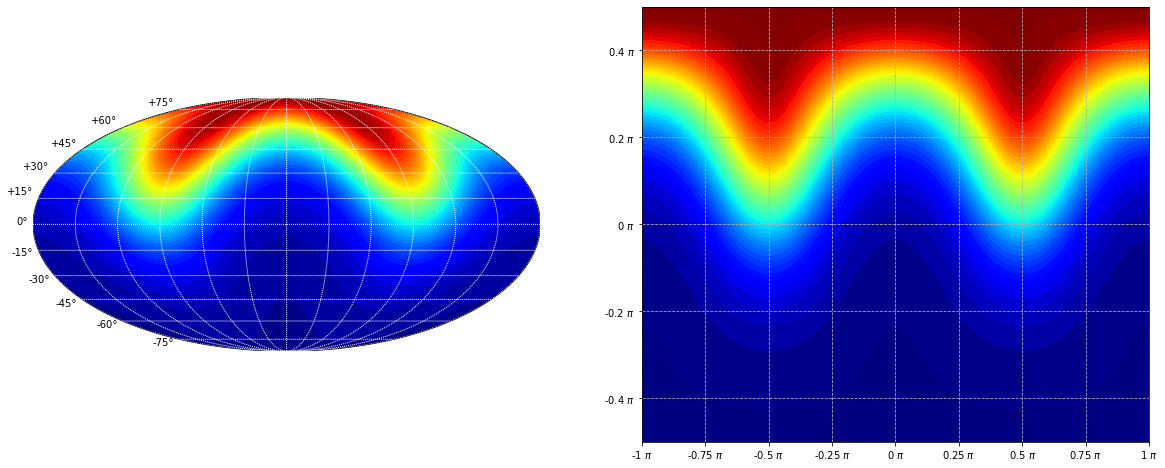

In [4]:


phi = np.pi / 2
theta = np.pi / 2
psi = np.pi / 2

beta = 1
kappa = 2*beta

kent_dist = kent(theta, phi, psi, kappa, beta)



import torch
from tqdm import tqdm



nr_grid_points = 100

phi_linspace = np.linspace(-np.pi, np.pi, nr_grid_points)
theta_linspace = np.linspace(-np.pi / 2, np.pi / 2, nr_grid_points)

nr_grid_points = len(phi_linspace)

dphi = phi_linspace[1] - phi_linspace[0]
dtheta = theta_linspace[1] - theta_linspace[0]

# NOTE: contourf takes array [X,Y] as argument where len(X) is number of columns and len(Y) number of rows. That is why probs[j][i]

probs = np.empty([nr_grid_points, nr_grid_points])
probs_with_cos = np.empty([nr_grid_points, nr_grid_points])

x = torch.zeros(nr_grid_points,nr_grid_points,3)
theta_values = torch.zeros(nr_grid_points,nr_grid_points)

for i, phi0 in tqdm(enumerate(phi_linspace)):

    for j, theta0 in enumerate(theta_linspace):

        x[j,i] = torch.tensor(T_spherical_to_cartesian(phi0, theta0)).float()
        theta_values[j,i] = torch.cos(torch.tensor(theta0)).float()            

# probs = mixture_power_spherical_density(x.view(-1,3), mu_list, k_list).reshape(nr_grid_points,nr_grid_points)
probs = kent_dist.pdf(x.view(-1,3).numpy()).reshape(nr_grid_points,nr_grid_points)
probs = torch.tensor(probs)
probs_with_cos = probs * theta_values.reshape(nr_grid_points,nr_grid_points)

X,Y = np.meshgrid(phi_linspace,theta_linspace)
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(121)
ax.grid(linestyle='--')
RAD = 180/np.pi
m = Basemap(ax=ax, projection='moll',lon_0=0,lat_0=0,resolution='c')
m.contourf(X*RAD, Y*RAD, probs, levels=50, cmap=plt.cm.jet,latlon=True)
m.drawparallels(np.arange(-90.,120.,15.),labels=[1,0,0,0],labelstyle='+/-',color = 'white') # draw parallels
m.drawmeridians(np.arange(0.,420.,30.),labels=[0,0,0,0],color = 'white')

# x,y=m(phi_mu_list*RAD,theta_mu_list*RAD)
# m.scatter(x, y,s=20,color='black')

ax = fig.add_subplot(122)
ax.grid(linestyle='--')
ax.contourf(phi_linspace/np.pi, theta_linspace/np.pi, probs, levels = 50, cmap = plt.cm.jet, extend='both')
# ax.scatter(phi_mu_list/np.pi, theta_mu_list/np.pi, s=20, color='black')

plt.gca().xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.gca().xaxis.set_major_locator(tck.MultipleLocator(base=0.25))
plt.gca().yaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
plt.gca().yaxis.set_major_locator(tck.MultipleLocator(base=0.2))


plt.show()    



In [5]:
kent_dist = kent(theta, phi, psi, kappa, beta)
kent_dist.rvs(100)

array([[-0.06813635, -0.1194341 ,  0.99050135],
       [-0.98758868,  0.04572404,  0.15025945],
       [ 0.28973895, -0.70201087,  0.65056289],
       [-0.05508472,  0.32064966,  0.94559477],
       [ 0.45696802,  0.49731086,  0.73747009],
       [ 0.40934639, -0.81748594,  0.4051571 ],
       [-0.09547248,  0.81169196,  0.57623014],
       [-0.29266321, -0.50441538, -0.81235052],
       [-0.2492485 , -0.33141748,  0.90996573],
       [-0.33680318,  0.44114432,  0.83183851],
       [-0.37946381, -0.80802027,  0.45067777],
       [-0.52006621,  0.81899656,  0.24243714],
       [ 0.75724561,  0.65311813,  0.00397343],
       [-0.10519697, -0.95386319,  0.28120919],
       [-0.42193981,  0.47780752,  0.77049774],
       [ 0.2993571 ,  0.51865445,  0.80086384],
       [ 0.03445957, -0.7629065 ,  0.64558981],
       [ 0.25372698,  0.74397724,  0.61815894],
       [ 0.36544189,  0.91338776,  0.179374  ],
       [-0.06988846,  0.17328138,  0.98238952],
       [-0.00800022, -0.98285911, -0.184

In [6]:
    
class KentData(torch.utils.data.Dataset):

    def __init__(self, nr_samples):

        
        phi = np.pi / 2
        theta = np.pi / 2
        psi = np.pi / 2

        beta = 1
        kappa = 2*beta

        self.kent_dist = kent(theta, phi, psi, kappa, beta)
        self.nr_samples = nr_samples
            
    def __len__(self):
        return self.nr_samples

    def __getitem__(self, idx):
        return self.kent_dist.rvs(1).squeeze()



In [8]:
TRAIN_SAMPLES = 100000

kent_data = KentData(nr_samples=TRAIN_SAMPLES)


In [9]:
train_loader = DataLoader(kent_data, batch_size=256, shuffle=True)

In [10]:
for idx, x in enumerate(train_loader):
    print(idx)
    print(x.shape)
    if idx == 5:
        break

0
torch.Size([256, 3])
1
torch.Size([256, 3])
2
torch.Size([256, 3])
3
torch.Size([256, 3])
4
torch.Size([256, 3])
5
torch.Size([256, 3])
